### LSTM CNN

In [3]:
import tensorflow as tf
print(tf.__version__)
import matplotlib.pyplot as plt

from absl import app
from absl import flags
from absl import logging


import tensorflow as tf
import numpy as np
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from sklearn.metrics import log_loss, accuracy_score

1.15.2


In [5]:
!pip install git+https://github.com/tensorflow/privacy

  Cloning https://github.com/tensorflow/privacy to /private/var/folders/yt/gg3wbfh95hjbxdzsdwzwbv4c0000gn/T/pip-req-build-ck96k6us
  Running command git clone -q https://github.com/tensorflow/privacy /private/var/folders/yt/gg3wbfh95hjbxdzsdwzwbv4c0000gn/T/pip-req-build-ck96k6us
     |████████████████████████████████| 522kB 3.1MB/s eta 0:00:01
     |████████████████████████████████| 102kB 13.2MB/s ta 0:00:01
  Created wheel for tensorflow-privacy: filename=tensorflow_privacy-0.2.2-cp37-none-any.whl size=83185 sha256=51f11f3afeec6276f05b3e1e5491801de711ad5a6fc66f28b5a128a4551e4fcd
  Stored in directory: /private/var/folders/yt/gg3wbfh95hjbxdzsdwzwbv4c0000gn/T/pip-ephem-wheel-cache-x07ptpsc/wheels/8a/e4/14/41d16468ac11ec804bd21cfb75fc2e24f96b9e4c5af778f576
  Created wheel for mpmath: filename=mpmath-1.1.0-cp37-none-any.whl size=532240 sha256=68fb1fb834530ff6bbc8a88abfcba023ce5449564f5ba6b0a13e986c62bedb5b
  Stored in directory: /Users/armandoordoricadelatorre/Library/Caches/pip/wheels/63

In [6]:

STOPWORDS = set(stopwords.words('english'))

import pandas as pd
from sklearn import preprocessing


from tensorflow_privacy.privacy.analysis.rdp_accountant import compute_rdp
from tensorflow_privacy.privacy.analysis.rdp_accountant import get_privacy_spent
from tensorflow_privacy.privacy.optimizers.dp_optimizer import DPAdamGaussianOptimizer


In [7]:
GradientDescentOptimizer = tf.compat.v1.train.GradientDescentOptimizer
AdamOptimizer = tf.compat.v1.train.AdamOptimizer

flags.DEFINE_boolean(
    'dpsgd', True, 'If True, train with DP-SGD. If False, '
    'train with vanilla SGD.')
flags.DEFINE_float('learning_rate', 0.005, 'Learning rate for training')
flags.DEFINE_float('noise_multiplier', 1.1,
                   'Ratio of the standard deviation to the clipping norm')
flags.DEFINE_float('l2_norm_clip', 1.0, 'Clipping norm')
flags.DEFINE_integer('batch_size', 250, 'Batch size')
flags.DEFINE_integer('epochs', 60, 'Number of epochs')
flags.DEFINE_integer(
    'microbatches', 250, 'Number of microbatches '
    '(must evenly divide batch_size)')
flags.DEFINE_string('model_dir', None, 'Model directory')

FLAGS = flags.FLAGS

embedding_dim = 100
max_length = 2000

In [63]:

def compute_epsilon(steps):
  """Computes epsilon value for given hyperparameters."""
  if FLAGS.noise_multiplier == 0.0:
    return float('inf')
  orders = [1 + x / 10. for x in range(1, 100)] + list(range(12, 64))
  sampling_probability = FLAGS.batch_size / 60000
  rdp = compute_rdp(q=sampling_probability,
                    noise_multiplier=FLAGS.noise_multiplier,
                    steps=steps,
                    orders=orders)
    
  # Delta is set to 1e-5 because product_reviews has 70000 training points.
  return get_privacy_spent(orders, rdp, target_delta=1e-5)[0]




### Importing the data

In [64]:



df = pd.read_csv('consumer_complaints.csv')
print(df.head(2).T)

# Create a new dataframe with two columns
df1 = df[['product', 'consumer_complaint_narrative']].copy()

df1 = df1[pd.notnull(df1['consumer_complaint_narrative'])]

# Renaming second column
df1.columns = ['product', 'consumer_complaint']

# Percentage of complaints with text
total = df1['consumer_complaint'].notnull().sum()
round((total / len(df) * 100), 1)

# print(pd.DataFrame(df.product.unique()).values)


/Users/armandoordoricadelatorre/.pyenv/versions/3.7.3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (5,11) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


                                                                     0  \
date_received                                               08/30/2013   
product                                                       Mortgage   
sub_product                                             Other mortgage   
issue                         Loan modification,collection,foreclosure   
sub_issue                                                          NaN   
consumer_complaint_narrative                                       NaN   
company_public_response                                            NaN   
company                                                   U.S. Bancorp   
state                                                               CA   
zipcode                                                          95993   
tags                                                               NaN   
consumer_consent_provided                                          NaN   
submitted_via                         

12.0

### Data Cleaning

                   0
0     DebtCollection
1        StudentLoan
2           Mortgage
3  CreditPrepaidCard
4       ConsumerLoan
5    CreditReporting
6        BankAccount
7     MoneyTransfers
8       PersonalLoan
9  FinancialServices
               product                                 consumer_complaint  \
258022  DebtCollection  On first contact from P & B Capitol Group, LLC...   
498755  DebtCollection  I am writing regarding this agencies illegal c...   
306486  DebtCollection  i got a call from a collection company regardi...   
261329     StudentLoan  We have a company sending a demand notice she ...   
495265        Mortgage  My name is XXXX XXXX. Our family lives in XXXX...   

        category_id  
258022            4  
498755            4  
306486            4  
261329            9  
495265            7  


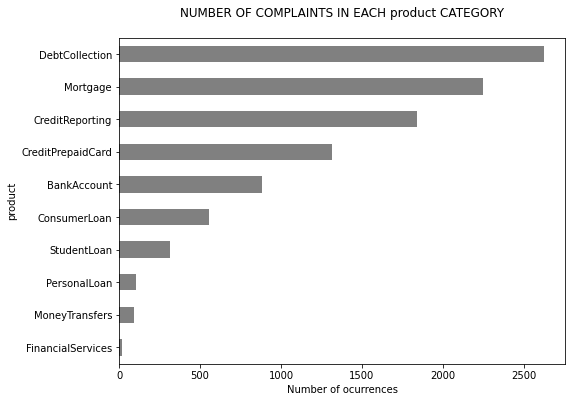

Length of labels10000
Length of product_comments10000
(7000, 1)
(2000, 1)
(1000, 1)
(7000, 2000)
(2000, 2000)
(1000, 2000)
21847
1


In [65]:

df2 = df1.sample(10000, random_state=1).copy()

# Renaming categories
df2.replace({'product':
                 {'Credit reporting, credit repair services, or other personal consumer reports':
                      'CreditReporting',
                  'Credit reporting': 'CreditReporting',
                  'Credit card': 'CreditPrepaidCard',
                  'Prepaid card': 'CreditPrepaidCard',
                  'Credit card or prepaid card': 'CreditPrepaidCard',
                  'Payday loan': 'PersonalLoan',
                  'Payday loan, title loan, or personal loan' : 'PersonalLoan',
                  'Money transfer': 'TransferServices',
                  'Virtual currency': 'TransferServices',
                  'Money transfer, virtual currency, or money service' : 'TransferServices',
                  'Student loan': 'StudentLoan',
                  'Checking or savings account': 'SavingsAccount',
                  'Vehicle loan or lease': 'VehicleLoan',
                  'Debt collection': 'DebtCollection',
                  'Bank account or service' : 'BankAccount',
                  'Other financial service': 'FinancialServices',
                  'Consumer Loan': 'ConsumerLoan',
                  'Money transfers': 'MoneyTransfers'}},
            inplace=True)


print(pd.DataFrame(df2['product'].unique()))

# Create a new column 'category_id' with label-encoded categories
le = preprocessing.LabelEncoder()
df2['category_id'] = le.fit_transform(df2['product'])

category_id_df = df2[['product', 'category_id']].drop_duplicates()
print(df2.head())

fig = plt.figure(figsize=(8, 6))
colors = ['grey', 'grey', 'grey', 'grey', 'grey', 'grey', 'grey', 'grey', 'grey',
          'grey', 'darkblue', 'darkblue', 'darkblue']
df2.groupby('product').consumer_complaint.count().sort_values().plot.barh(
    ylim=0, color=colors, title='NUMBER OF COMPLAINTS IN EACH product CATEGORY\n')
plt.xlabel('Number of ocurrences', fontsize=10)
plt.show()

product_comments = df2['consumer_complaint'].values  # Collection of documents
product_type = df2['category_id'].values # Target or the labels we want to predict (i.e., the 13 different complaints of products)

print("Length of labels" + str(len(product_type)))
print("Length of product_comments" + str(len(product_comments)))

complains = []
labels = []
for i in range(0, len(product_comments)):
    complain = product_comments[i]
    labels.append(product_type[i])
    complain = complain.replace('XX', '')
    complain = complain.replace('.', '')
    for word in STOPWORDS:
        token = ' ' + word + ' '
        complain = complain.replace(token, ' ')
        complain = complain.replace(' ', ' ')
    complains.append(complain)


tokenizer = Tokenizer()
tokenizer.fit_on_texts(complains)

word_index = tokenizer.word_index
vocab_size = len(word_index)

sequences = tokenizer.texts_to_sequences(product_comments)
padded = pad_sequences(sequences, maxlen=max_length)

train_size = int(len(product_comments) * 0.7)
validation_size = int(len(product_comments) * 0.2)

training_sequences = padded[0:train_size]
train_labels = labels[0:train_size]

validation_sequences = padded[train_size:train_size+validation_size]
validation_labels = labels[train_size:train_size+validation_size]

test_sequences = padded[train_size + validation_size:]
test_labels = labels[train_size + validation_size:]

training_label_seq = np.reshape(np.array(train_labels), (len(train_labels), 1))
validation_label_seq = np.reshape(np.array(validation_labels), (len(validation_labels), 1))
test_label_seq = np.reshape(np.array(test_labels), (len(test_labels), 1))

print(training_label_seq.shape)
print(validation_label_seq.shape)
print(test_label_seq.shape)

print(training_sequences.shape)
print(validation_sequences.shape)
print(test_sequences.shape)

print(vocab_size)
print(word_index['i'])




### Getting pre-trained word embeddings

In [67]:

embeddings_index = {};
with open('glove_6B/glove.6B.100d.txt') as f:
    for line in f:
        values = line.split();
        word = values[0];
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs;

embeddings_matrix = np.zeros((vocab_size + 1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector

print(len(embeddings_matrix))


21848


### Defining the model

In [68]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size + 1, embedding_dim, input_length=max_length, weights=[embeddings_matrix],
                              trainable=False),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv1D(64, 5, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=4),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(13, activation='softmax')
])
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 2000, 100)         2184800   
_________________________________________________________________
dropout_1 (Dropout)          (None, 2000, 100)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1996, 64)          32064     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 499, 64)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_1 (Dense)              (None, 13)                845       
Total params: 2,250,733
Trainable params: 65,933
Non-trainable params: 2,184,800
_______________________________________

In [39]:
# if FLAGS.dpsgd:
#         optimizer = DPAdamGaussianOptimizer(
#             l2_norm_clip=FLAGS.l2_norm_clip,
#             noise_multiplier=FLAGS.noise_multiplier,
#             num_microbatches=FLAGS.microbatches,
#             learning_rate=FLAGS.learning_rate)
# else:
#     optimizer = AdamOptimizer()

In [40]:
model.compile(loss='sparse_categorical_crossentropy', optimizer= AdamOptimizer(), metrics=['accuracy'])

In [69]:
num_epochs = 10

history = model.fit(training_sequences, training_label_seq, epochs=num_epochs,
                    validation_data=(validation_sequences, validation_label_seq), verbose=2)



Train on 7000 samples, validate on 2000 samples
Epoch 1/10
7000/7000 - 147s - loss: 1.8404 - acc: 0.3124 - val_loss: 1.7092 - val_acc: 0.4010
Epoch 2/10
7000/7000 - 138s - loss: 1.4041 - acc: 0.5324 - val_loss: 1.3131 - val_acc: 0.5620
Epoch 3/10
7000/7000 - 132s - loss: 1.0808 - acc: 0.6407 - val_loss: 1.0123 - val_acc: 0.6755
Epoch 4/10
7000/7000 - 139s - loss: 0.8949 - acc: 0.7094 - val_loss: 0.9623 - val_acc: 0.7040
Epoch 5/10
7000/7000 - 133s - loss: 0.7968 - acc: 0.7484 - val_loss: 0.8459 - val_acc: 0.7380
Epoch 6/10
7000/7000 - 137s - loss: 0.7153 - acc: 0.7749 - val_loss: 0.8094 - val_acc: 0.7560
Epoch 7/10
7000/7000 - 131s - loss: 0.6541 - acc: 0.7966 - val_loss: 0.7553 - val_acc: 0.7690
Epoch 8/10
7000/7000 - 130s - loss: 0.6044 - acc: 0.8076 - val_loss: 0.7534 - val_acc: 0.7760
Epoch 9/10
7000/7000 - 129s - loss: 0.5651 - acc: 0.8259 - val_loss: 0.7245 - val_acc: 0.7855
Epoch 10/10
7000/7000 - 196s - loss: 0.5305 - acc: 0.8346 - val_loss: 0.6961 - val_acc: 0.7935


### Plotting Loss and Accuracy 

In [73]:
history.history

{'loss': [1.8403603722708566,
  1.40413900579725,
  1.0808313197408403,
  0.8949111199378967,
  0.7968171206883021,
  0.7152983919552395,
  0.6540933719362532,
  0.6043529423134667,
  0.565142025572913,
  0.530483251128878],
 'acc': [0.31242856,
  0.53242856,
  0.6407143,
  0.70942855,
  0.7484286,
  0.77485716,
  0.79657143,
  0.8075714,
  0.82585716,
  0.8345714],
 'val_loss': [1.709171877861023,
  1.3131150798797608,
  1.0122896223068236,
  0.9623257007598877,
  0.8458749542236328,
  0.8093898091316223,
  0.7552811517715454,
  0.7534219884872436,
  0.7245237038135529,
  0.6960545473098755],
 'val_acc': [0.401,
  0.562,
  0.6755,
  0.704,
  0.738,
  0.756,
  0.769,
  0.776,
  0.7855,
  0.7935]}

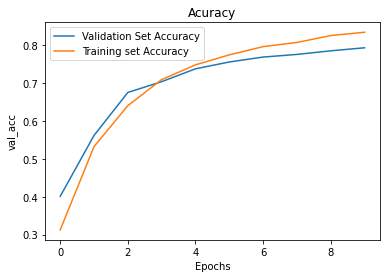

In [76]:
plt.plot(history.history["val_acc"])
plt.plot(history.history["acc"])


# plt.plot(history.history['val_' + string])
plt.xlabel("Epochs")
plt.ylabel("val_acc")
plt.legend(["Validation Set Accuracy", "Training set Accuracy"])
plt.title("Acuracy")
plt.show()

# history.history


In [77]:
history.history

{'loss': [1.8403603722708566,
  1.40413900579725,
  1.0808313197408403,
  0.8949111199378967,
  0.7968171206883021,
  0.7152983919552395,
  0.6540933719362532,
  0.6043529423134667,
  0.565142025572913,
  0.530483251128878],
 'acc': [0.31242856,
  0.53242856,
  0.6407143,
  0.70942855,
  0.7484286,
  0.77485716,
  0.79657143,
  0.8075714,
  0.82585716,
  0.8345714],
 'val_loss': [1.709171877861023,
  1.3131150798797608,
  1.0122896223068236,
  0.9623257007598877,
  0.8458749542236328,
  0.8093898091316223,
  0.7552811517715454,
  0.7534219884872436,
  0.7245237038135529,
  0.6960545473098755],
 'val_acc': [0.401,
  0.562,
  0.6755,
  0.704,
  0.738,
  0.756,
  0.769,
  0.776,
  0.7855,
  0.7935]}

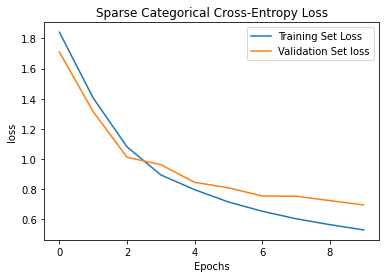

In [78]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
# plt.plot(history.history['val_' + string])
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.legend(["Training Set Loss", 'Validation Set loss'])
plt.title("Sparse Categorical Cross-Entropy Loss")
plt.show()


### Summary

In [79]:
scores = model.evaluate(test_sequences, test_label_seq, verbose=0)
print("Accuracy: %.2f%%" % (scores[1] * 100))

output_test = model.predict(test_sequences)
print(np.shape(output_test))
final_pred = np.argmax(output_test, axis=1)
print(np.shape(final_pred))
print(np.shape(test_label_seq))
final_pred_list = np.reshape(final_pred, (len(test_sequences), 1))
print(np.shape(final_pred_list))

results = confusion_matrix(test_label_seq, final_pred_list)
print(results)

precisions, recall, f1_score, true_sum = metrics.precision_recall_fscore_support(test_label_seq, final_pred_list)
print("Multi-label Classification LSTM CNN Precision =", precisions)
print("Multi-label Classification LSTM CNN Recall=", recall)
print("Multi-label Classification LSTM CNN F1 Score =", f1_score)
print('Multi-label Classification Accuracy: {}'.format((accuracy_score(test_label_seq, final_pred_list))))

classes = np.array(range(0, 13))

Accuracy: 77.80%
(1000, 13)
(1000,)
(1000, 1)
(1000, 1)
[[ 63   0  18   2   3   0   6   0   0]
 [  0  28   9   4   8   0   7   0   1]
 [ 13   0  94   7   9   0   4   0   1]
 [  0   4   7 127  27   0   3   0   0]
 [  0   6   5  12 226   0  10   0   5]
 [ 10   0   2   0   0   0   1   0   0]
 [  4   1   2   4   5   0 224   0   1]
 [  0   0   0   0   4   0   4   0   3]
 [  1   0   0   0   5   0   4   0  16]]
Multi-label Classification LSTM CNN Precision = [0.69230769 0.71794872 0.68613139 0.81410256 0.78745645 0.
 0.85171103 0.         0.59259259]
Multi-label Classification LSTM CNN Recall= [0.68478261 0.49122807 0.734375   0.75595238 0.85606061 0.
 0.92946058 0.         0.61538462]
Multi-label Classification LSTM CNN F1 Score = [0.68852459 0.58333333 0.70943396 0.78395062 0.82032668 0.
 0.88888889 0.         0.60377358]
Multi-label Classification Accuracy: 0.778
